# データの取得方法

ここではQuandl.comからのデータを受け取っています。今回入手した日経平均株価は、
時間、開始値、最高値、最低値、終値のデータを入手していますが、古いデータは終値しかないようですので、終値を用います。
*** TODO いつからデータを入手することが最も効果的かを考える。（処理時間と制度に影響が出るため）

In [158]:
import quandl
data = quandl.get('NIKKEI/INDEX')

In [2]:
data[:5]

,Open Price,High Price,Low Price,Close Price
Date,,,,
1950-01-04,NaN,NaN,0.0,108.56
1950-01-05,NaN,NaN,0.0,105.54
1950-01-06,NaN,NaN,0.0,102.64
1950-01-09,NaN,NaN,0.0,102.78
1950-01-10,NaN,NaN,0.0,101.36


In [196]:
data_normal = (((data['Close Price']).to_frame())[-10000:-1])['Close Price']
data_normal[-10:-1] # 最新のデータ１０件を表示

Date
2017-07-21    20099.75
2017-07-24    19975.67
2017-07-25    19955.20
2017-07-26    20050.16
2017-07-27    20079.64
2017-07-28    19959.84
2017-07-31    19925.18
2017-08-01    19985.79
2017-08-02    20080.04
Name: Close Price, dtype: float64

抜けデータが目立ったため、週単位でのデータを入手します

In [197]:
data_normal = data_normal.fillna(method='pad').resample('W-MON').fillna(method='pad')

In [198]:
data_normal[:5]

Date
1977-02-07    5078.75
1977-02-14    4979.03
1977-02-21    5023.52
1977-02-28    5079.11
1977-03-07    5034.52
Freq: W-MON, Name: Close Price, dtype: float64

In [166]:
type(data_normal.index[0])
data_normal.index

DatetimeIndex(['1977-02-07', '1977-02-14', '1977-02-21', '1977-02-28',
               '1977-03-07', '1977-03-14', '1977-03-21', '1977-03-28',
               '1977-04-04', '1977-04-11',
               ...
               '2017-06-05', '2017-06-12', '2017-06-19', '2017-06-26',
               '2017-07-03', '2017-07-10', '2017-07-17', '2017-07-24',
               '2017-07-31', '2017-08-07'],
              dtype='datetime64[ns]', name='Date', length=2114, freq='W-MON')

# データの用い方

必要となるpythonパッケージのインポートを行っています。
*** TODO 実装はClojureで行いため、これに相当するパッケージを検索、作成を行う

In [70]:
import numpy as np
import pandas as pd
from scipy import stats
from pandas.core import datetools
# grapgh plotting 
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline

# settings graph size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

# model 
import statsmodels.api as sm

以下のグラフから、2000年ごろのデータからの推測でも十分に予測が行える可能性が伺えます。

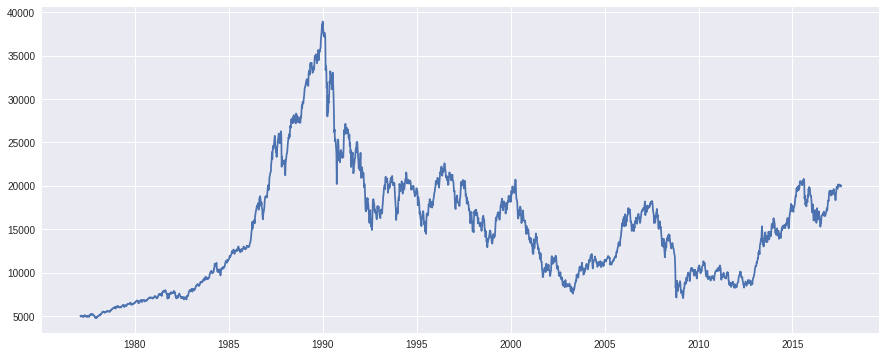

In [46]:
plt.plot(data_normal)

ARIMAモデルでモデル推定を行うための下準備として、株価の変化量を取得します。

In [205]:
# ARIMA model prediction ... (This is self thought (not automatically))
diff = data_normal - data_normal.shift()
diff = diff.dropna()
diff.head()

Date
1977-02-14   -99.72
1977-02-21    44.49
1977-02-28    55.59
1977-03-07   -44.59
1977-03-14   -71.92
Freq: W-MON, Name: Close Price, dtype: float64

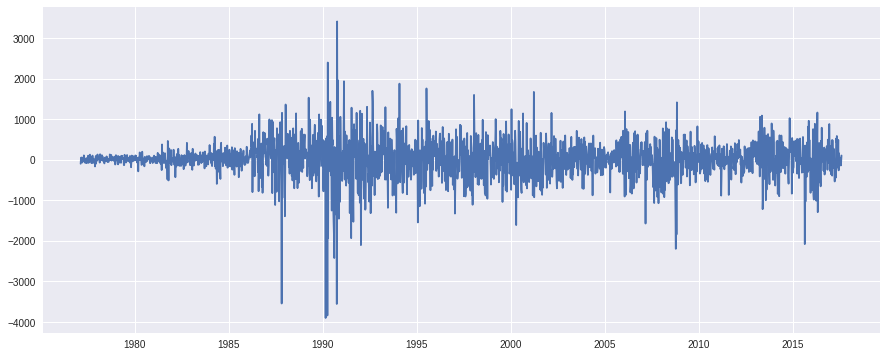

In [72]:
# difference plot 
plt.plot(diff)

AICを求めてモデルの良さを計算しますが、やや時間（約三分）がかかってしまします。
（SARIMAモデルでこれを行うと、更に時間がかかります）
*** TODO 実行時間の計測と最適化・マシンスペックの向上と性能の関係の調査

In [200]:
# automatically ARIMA prediction function (using AIC)
resDiff = sm.tsa.arma_order_select_ic(diff, ic='aic', trend='nc')
# few Times ...(orz...)

先程の実行結果から、AR=2, MA=2という値の場合が最も良いモデルになることがわかりました。

In [201]:
resDiff 
# search min
resDiff['aic_min_order']

(2, 2)

### 比較のためSARIMAモデルではなく、ARIMAモデルでの推定を行ってみます。

こちらの実行はそれほど時間がかかりません。

In [170]:
# we found x = x, y= y autopmatically
from statsmodels.tsa.arima_model import ARIMA
ARIMAx_1_y = ARIMA(data_normal, 
                  order=(resDiff['aic_min_order'][0], 1,
                  resDiff['aic_min_order'][1])).fit(dist=False)
# AR = resDiff[...][0] / I = 1 / MA = resDiff[...][1]
ARIMAx_1_y.params

const                  7.071274
ar.L1.D.Close Price   -1.690125
ar.L2.D.Close Price   -0.931886
ma.L1.D.Close Price    1.633454
ma.L2.D.Close Price    0.885898
dtype: float64

予測のブレがあまりないことが伺えます

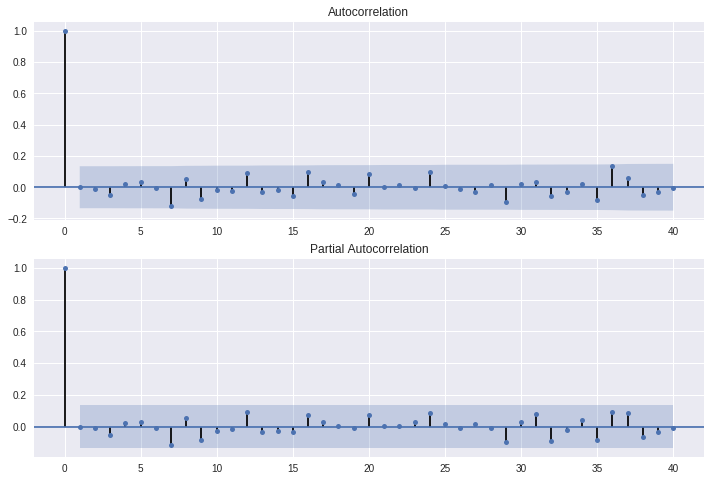

In [34]:
# check Residual error (... I think this is "White noise")
# this is not Arima ... (Periodicity remained)
resid = ARIMAx_1_y.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

# ok? 

In [ ]:
# We test SARIMA_model

### SARIMAモデルでの推定を行ってみます。

ARIMAモデルの実行がそれほど時間がかからなかったのに対して、SARIMAモデルはやや時間がかかること、Wariningが出ることが難点です。

In [242]:
# predict SARIMA model  by  myself (not automatically) 
import statsmodels.api as sm

SARIMAx_1_y_111 = sm.tsa.SARIMAX(data_normal, 
                                 order=(2,1,2),seasonal_order=(1,1,1,12))
SARIMAx_1_y_111 = SARIMAx_1_y_111.fit()
# order ... from ARIMA model // seasonal_order ... 1 1 1 ... ?  
print(SARIMAx_1_y_111.summary())

# maybe use "Box-Jenkins method" ...
# https://github.com/statsmodels/statsmodels/issues/3620 for error

                                 Statespace Model Results                                 
Dep. Variable:                        Close Price   No. Observations:                 2114
Model:             SARIMAX(2, 1, 2)x(1, 1, 1, 12)   Log Likelihood              -15992.035
Date:                            Sun, 06 Aug 2017   AIC                          31998.069
Time:                                    19:01:40   BIC                          32037.663
Sample:                                02-07-1977   HQIC                         32012.567
                                     - 08-07-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0041    139.303  -2.95e-05      1.000    -273.032     273.024
ar.L2          0.9958    146.244   

おおよそ見た限りではARIMAモデルと大差はないようですが、他の論文を読む限りではこちらの手法のほうが推測が上手く行くようです。
*** TODO データを少なくした場合の実行結果

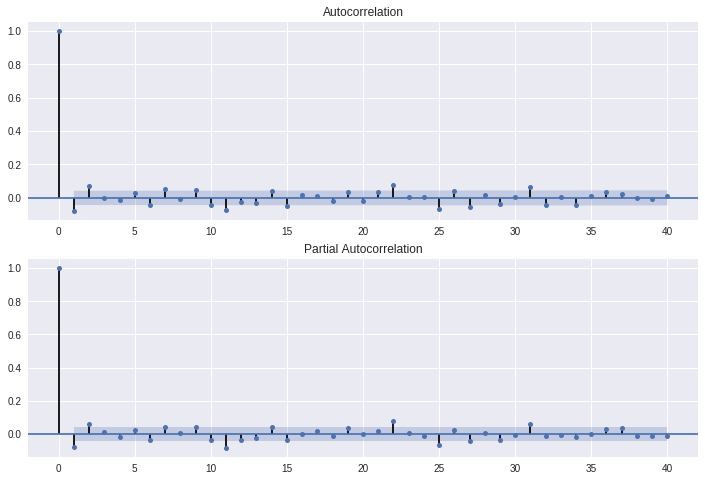

In [74]:
# check Residual error
residSARIMA = SARIMAx_1_y_111.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=40, ax=ax2)

In [81]:
# prediction
pred = SARIMAx_1_y_111.predict(start = 1, end = '2018-01-15')
# (print(SARIMAx_1_y_111.__doc__))

# 本来は未来（インデクスの外）まで予測ができるはずなのですが、
# 何故かエラーが出てしまうので、既存のデータ部分だけ予測します

# TODO エラーの原因特定

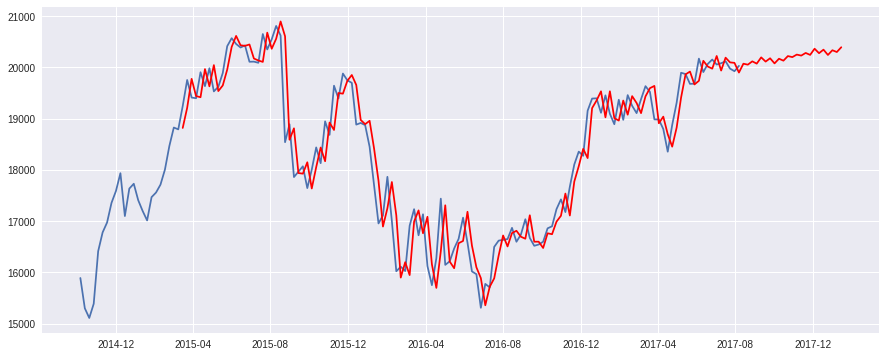

In [87]:
# plot real data and predict data 
plt.plot(data_normal[:-150:-1])
plt.plot(pred[:-150:-1], "r")

以下が予測を結合したもの

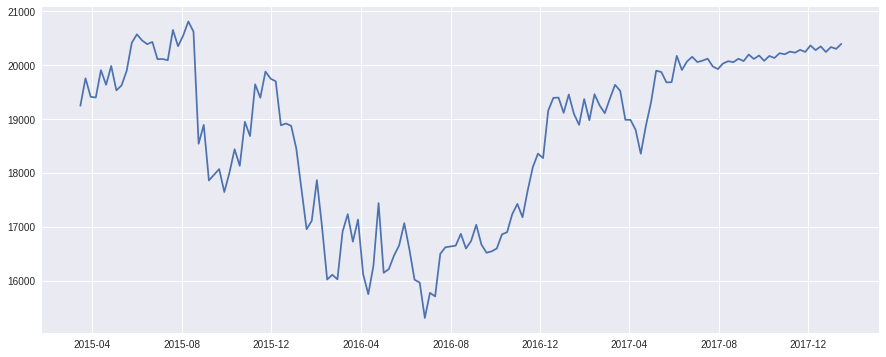

In [51]:
data_extra = pd.concat( [data_normal, pred[data_normal.index[-1] + 1:]] )
plt.plot(data_extra[:-150:-1])

青が実測値、赤が予測値です。それに近い値を計測できたのではないでしょうか？

## 後のために関数化しておく

In [ ]:
# require 
import quandl
import numpy as np
import pandad as pd 
from scipy import stats
from pandas.coda import datatools
import statsmodels.api as sm

In [275]:
def get_data(quandl_name):
    data = quandl.get(quandl_name)
    return data

def set_data(data):
    data_normal = (((data['Close Price']).to_frame())[-10000:-1])['Close Price']
    data_normal = data_normal.fillna(method='pad').resample('W-MON').fillna(method='pad')
    return data_normal

def sarima(quandl_name):
    data_normal = set_data(get_data(quandl_name))
    diff = (data_normal - (data_normal.shift())).dropna()
    resDiff = aic(diff)['aic_min_order']
    ar = resDiff[0]
    ma = resDiff[1]
    SARIMAx_1_y_111 =  \
    sm.tsa.SARIMAX(data_normal, order=(int(ar),1, int(ma)),seasonal_order=(1,1,1,12))
    return  SARIMAx_1_y_111

def pred_data(SARIMAx_1_y_111, predict_date):
    SARIMAx_1_y_111 = SARIMAx_1_y_111.fit()
    print(SARIMAx_1_y_111.summary())
    pred = SARIMAx_1_y_111.predict(start = 1, end = predict_date)
    return pd.concat( [data_normal, pred[data_normal.index[-1] + 1:]] )

def aic (diff):
    return (sm.tsa.arma_order_select_ic(diff, ic='aic', trend='nc')) 


# 以上をまとめたもの
def predict_data(quandl_name, predict_data):
    sarima_model = sarima(quandl_name)
    return pred_data(sarima_model, predict_data)

In [277]:
predict_res = predict_data('NIKKEI/INDEX','2018-01-15')

                                 Statespace Model Results                                 
Dep. Variable:                        Close Price   No. Observations:                 2114
Model:             SARIMAX(2, 1, 2)x(1, 1, 1, 12)   Log Likelihood              -15992.035
Date:                            Sun, 06 Aug 2017   AIC                          31998.069
Time:                                    19:31:47   BIC                          32037.663
Sample:                                02-07-1977   HQIC                         32012.567
                                     - 08-07-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0041    139.303  -2.95e-05      1.000    -273.032     273.024
ar.L2          0.9958    146.244   

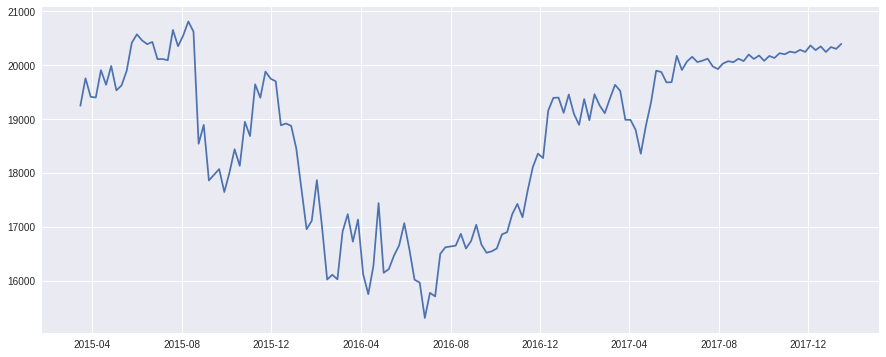

In [284]:
plt.plot(predict_res[:-150:-1])

# ランダムフォレストによる欠損値補完